In [2]:
import cv2
import numpy as np
import matplotlib . pyplot as plt
# termination criteria
criteria = ( cv2 . TERM_CRITERIA_EPS + cv2 . TERM_CRITERIA_MAX_ITER , 30 , 0.001)
calibration_flags = cv2 . fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2 . fisheye .CALIB_FIX_SKEW
# inner size of chessboard
width = 9
height = 6
square_size = 0.025 # 0.025 meters

# prepare object points , like (0 ,0 ,0) , (1 ,0 ,0) , (2 ,0 ,0) .... ,(8 ,6 ,0)
objp = np . zeros (( height * width , 1 , 3) , np . float64 )
objp [: , 0 , :2] = np . mgrid [0: width , 0: height ]. T . reshape ( -1 , 2)
objp = objp * square_size # Create real world coords . Use your metric .
# Arrays to store object points and image points from all the images .
objpoints = [] # 3 d point in real world space
imgpoints_left = [] # 2 d points in image plane .
imgpoints_right = [] # 2 d points in image plane .
img_width = 640
img_height = 480
image_size = ( img_width , img_height )
path = ""
image_dir = path + "pairs/"

number_of_images = 50
for i in range (1 , number_of_images ) :
# read image
    img_left = cv2 . imread ( image_dir + "left_%02d.png"%i )
    img_right = cv2 . imread ( image_dir + "right_%02d.png"%i )
    left_gray = cv2.cvtColor(img_left , cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(img_right , cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    left_ret , left_corners = cv2 . findChessboardCorners ( left_gray , ( width , height ) , cv2 .
    CALIB_CB_ADAPTIVE_THRESH + cv2 . CALIB_CB_FAST_CHECK + cv2 .
    CALIB_CB_NORMALIZE_IMAGE )

    right_ret , right_corners = cv2 . findChessboardCorners ( right_gray , ( width , height ) , cv2.CALIB_CB_ADAPTIVE_THRESH + cv2 . CALIB_CB_FAST_CHECK + cv2 .
    CALIB_CB_NORMALIZE_IMAGE )

    Y , X , channels = img_left . shape

    # skip images where the corners of the chessboard are too close to the edges of

    if ( left_ret == True ) :
        minRx = left_corners [: ,: ,0]. min ()
        maxRx = left_corners [: ,: ,0]. max ()
        minRy = left_corners [: ,: ,1]. min ()
        maxRy = left_corners [: ,: ,1]. max ()
        border_threshold_x = X /12
        border_threshold_y = Y /12
        x_thresh_bad = False
        if ( minRx < border_threshold_x ) :
            x_thresh_bad = True
        y_thresh_bad = False
        if ( minRy < border_threshold_y ) :
            y_thresh_bad = True
        if ( y_thresh_bad == True ) or ( x_thresh_bad == True ) :
            continue

    if ( right_ret == True ) :
        minRx = right_corners [: ,: ,0]. min ()
        maxRx = right_corners [: ,: ,0]. max ()
        minRy = right_corners [: ,: ,1]. min ()
        maxRy = right_corners [: ,: ,1]. max ()
        border_threshold_x = X /12
        border_threshold_y = Y /12
        x_thresh_bad = False
        if ( minRx < border_threshold_x ) :
            x_thresh_bad = True
        y_thresh_bad = False
        if ( minRy < border_threshold_y ) :
            y_thresh_bad = True
        if ( y_thresh_bad == True ) or ( x_thresh_bad == True ) :
            continue

        if left_ret == True and right_ret == True:
            # Only append objpoints once per image pair
            objpoints.append(objp)
            
            # Process left image
            corners2_left = cv2.cornerSubPix(left_gray, left_corners, (3, 3), (-1, -1), criteria)
            imgpoints_left.append(corners2_left)
            cv2.drawChessboardCorners(img_left, (width, height), corners2_left, left_ret)
            cv2.imshow("Corners_Left", img_left)
            
            # Process right image
            corners2_right = cv2.cornerSubPix(right_gray, right_corners, (3, 3), (-1, -1), criteria)
            imgpoints_right.append(corners2_right)
            cv2.drawChessboardCorners(img_right, (width, height), corners2_right, right_ret)
            cv2.imshow("Corners_Right", img_right)
            
            cv2.waitKey(5)
        else:
            print("Chessboard couldn't be detected in one or both images. Image pair:", i)
            continue

N_OK_left = len ( objpoints )
N_OK_right = len ( objpoints )

K_left = np . zeros (( 3 , 3) , np . float64 )
K_right = np . zeros (( 3 , 3) , np . float64 )

D_left = np . zeros (( 4 , 1) , np . float64 )
D_right = np . zeros (( 4 , 1) , np . float64 )

rvecs_left = [np.zeros((1,1,3), np.float64) for i in range(N_OK_left)]
rvecs_right = [np.zeros((1,1,3), np.float64) for i in range(N_OK_right)]

tvecs_left = [np.zeros((1,1,3), np.float64) for i in range(N_OK_left)]
tvecs_right = [np.zeros((1,1,3), np.float64) for i in range(N_OK_right)]

ret_left, K_left, D_left, rvecs_left, tvecs_left = cv2.fisheye.calibrate(
    objpoints, imgpoints_left, image_size, K_left, D_left, rvecs_left, tvecs_left,
    criteria=criteria, flags=calibration_flags)

ret_right, K_right, D_right, rvecs_right, tvecs_right = cv2.fisheye.calibrate(
    objpoints, imgpoints_right, image_size, K_right, D_right, rvecs_right, tvecs_right,
    criteria=criteria, flags=calibration_flags)
    

cv2.destroyAllWindows()

In [3]:
imgpointsLeft = np . asarray ( imgpoints_left , dtype = np . float64 )
imgpointsRight = np . asarray ( imgpoints_right , dtype = np . float64 )

( RMS , _ , _ , _ , _ , rotationMatrix , translationVector ) = cv2 . fisheye . stereoCalibrate (
objpoints , imgpointsLeft , imgpointsRight ,
K_left , D_left ,
K_right , D_right ,
image_size , None , None ,
cv2 . CALIB_FIX_INTRINSIC ,
( cv2 . TERM_CRITERIA_EPS + cv2 . TERM_CRITERIA_MAX_ITER , 30 , 0.01) )

R2 = np . zeros ([3 ,3])
P1 = np . zeros ([3 ,4])
P2 = np . zeros ([3 ,4])
Q = np . zeros ([4 ,4])
# Rectify calibration results

(leftRectification , rightRectification , leftProjection , rightProjection , dispartityToDepthMap ) = cv2 . fisheye . stereoRectify (
K_left , D_left ,
K_right , D_right ,
image_size ,
rotationMatrix , translationVector ,
0 , R2 , P1 , P2 , Q ,
cv2 . CALIB_ZERO_DISPARITY , (0 ,0) , 0 , 0)

map1_left , map2_left = cv2 . fisheye . initUndistortRectifyMap (
K_left , D_left , leftRectification ,
leftProjection , image_size , cv2 . CV_16SC2 )

map1_right , map2_right = cv2 . fisheye . initUndistortRectifyMap (
K_right , D_right , rightRectification ,
rightProjection , image_size , cv2 . CV_16SC2 )

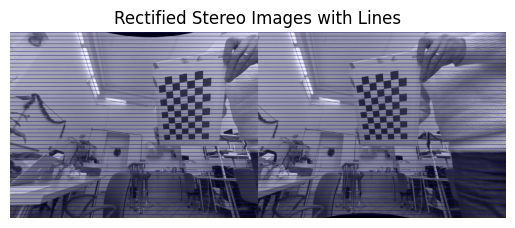

In [ ]:
img_l = cv2.imread(image_dir + "left_%02d.png"%25)

img_r = cv2.imread(image_dir + "right_%02d.png"%25)

dst_L = cv2 . remap ( img_l , map1_left , map2_left , cv2 . INTER_LINEAR )
dst_R = cv2 . remap ( img_r , map1_right , map2_right , cv2 . INTER_LINEAR )

N , XX , YY = dst_L . shape [:: -1] # RGB image size
visRectify = np . zeros (( YY , XX *2 , N ) , np . uint8 ) # create a new image with a new size
( height , 2* width )
visRectify [: ,0: XX : ,:] = dst_L # left image assignment
visRectify [: , XX : XX *2: ,:] = dst_R # right image assignment
# draw horizontal lines
for y in range (0 , YY ,10) :
    cv2.line(visRectify, (0, y), (XX * 2, y), (255, 0, 0))
plt.imshow(cv2.cvtColor(visRectify, cv2.COLOR_BGR2RGB))
plt.title('Rectified Stereo Images with Lines')
plt.axis('off')  
plt.show()  